In [1]:
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import os

from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint


PROJECT_CWD = r"/workspace"

print(os.getcwd())
os.chdir(PROJECT_CWD)
print(os.getcwd())

/workspace/playgrounds
/workspace


In [2]:
from my_packages.classes.aux_classes import Grid
from my_packages.classes.dipole_array import FlatDipoleArray

# dipoles should be places on a plane with a normal vector pointing in the z-direction
# start by placing the dipoles on a regular grid

# define the grid
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 0. # we can place the dipoles on the xy-plane - the height of the dipoles
# can be considered in the inspection height.

grid_resolution = 50

grid = np.mgrid[
    xbounds[0]:xbounds[1]:grid_resolution*1j, 
    ybounds[0]:ybounds[1]:grid_resolution*1j, 
    dipole_height:dipole_height:1j]
grid = Grid(grid)


In [3]:
from my_packages.classes.dipole_array import FlatDipoleArray
from my_packages.classes.dipole_fields import DFHandler_over_Substrate
from my_packages.classes.model_components import UniformEMSpace, Substrate

resolution= 21
def generate_random_mask(n, m):
    mask = np.random.randint(2, size=(n, m))
    return mask

def generate_random_orientation_xy(num_dipoles):
    orientation_mask = np.random.randint(2, size=(num_dipoles))
    new_orientation_mask = np.zeros((num_dipoles, 2), dtype=float)

    new_orientation_mask[orientation_mask == 0] = [0, np.pi/2]
    new_orientation_mask[orientation_mask == 1] = [np.pi/2, np.pi/2]
    return new_orientation_mask

def generate_random_moments(num_dipoles):
    moments_r, moments_i = np.random.uniform(0.2, 1, size=(2, num_dipoles))
    return moments_r+1j*moments_i

def from_dense_grid_to_centercell_grid(grid, cellgrid_shape):
    """
    grid: Grid object
    cellgrid_shape: tuple of (n, m) where n and m are integers
    """
    xbounds, ybounds = grid.bounds()[:-1]
    x = np.linspace(xbounds[0], xbounds[1], cellgrid_shape[0]+1) 
    x = np.diff(x)/2 + x[:-1]

    y = np.linspace(ybounds[0], ybounds[1], cellgrid_shape[1]+1)
    y = np.diff(y)/2 + y[:-1]

    return Grid(np.meshgrid(x, y, grid.z, indexing="ij"))


mask = generate_random_mask(resolution, resolution)

def from_mask_to_dipole_positions2D(mask, grid):
    """
    mask: 2D array of 0's and 1's
    grid: Grid object
    """
    xbounds, ybounds, _ = grid.bounds()
    x = np.linspace(xbounds[0], xbounds[1], mask.shape[0])
    y = np.linspace(ybounds[0], ybounds[1], mask.shape[1])
    x, y = np.meshgrid(x, y)
    x = x[mask == 1]
    y = y[mask == 1]
    z = np.zeros_like(x)
    return np.vstack((x, y, z)).T



def from_mask_to_dipole_array():
    pass

r0_grid = from_dense_grid_to_centercell_grid(grid, mask.shape)
r0 = from_mask_to_dipole_positions2D(mask, r0_grid)
N_dipoles = len(r0)
ors = generate_random_orientation_xy(N_dipoles)
moments = generate_random_moments(N_dipoles)
f = [1e9]
dipole_height = 3e-3

# measurement points
probe_heights = 1e-7, 1.2e-2
substrate_thickness = 1.4e-2
x = np.linspace(xbounds[0]*1.2, xbounds[1]*1.2, grid_resolution)
y = np.linspace(ybounds[0]*1.2, ybounds[1]*1.2, grid_resolution)
z = list(probe_heights)
r = np.meshgrid(x, y, z, indexing="ij")
r = Grid(r)

dipole_array = FlatDipoleArray(f=f, height=dipole_height, r0=r0, orientations=ors, moments=np.expand_dims(moments, axis=-1), type="Magnetic")
EM_space = UniformEMSpace(r=r)
substrate = Substrate(x_size=0.01, y_size=0.01, thickness=substrate_thickness, material_name="FR4_epoxy")


dfh = DFHandler_over_Substrate(EM_space=EM_space, substrate=substrate, dipole_array=dipole_array)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x (mm)', ylabel='y (mm)'>)

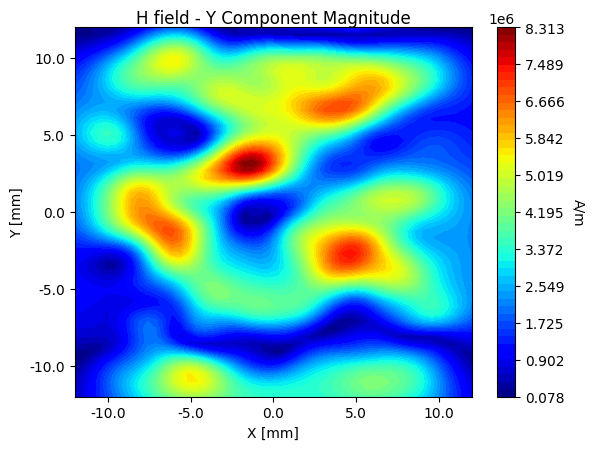

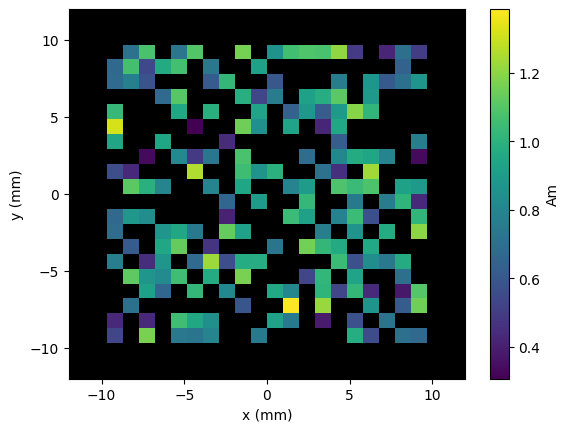

In [4]:
fig, ax = plt.subplots()

dfh.evaluate_fields().H.run_scan("y", index = 0.7e-2).plot(ax=ax)
dfh.dh_magnetic.plot_moment_intensity()

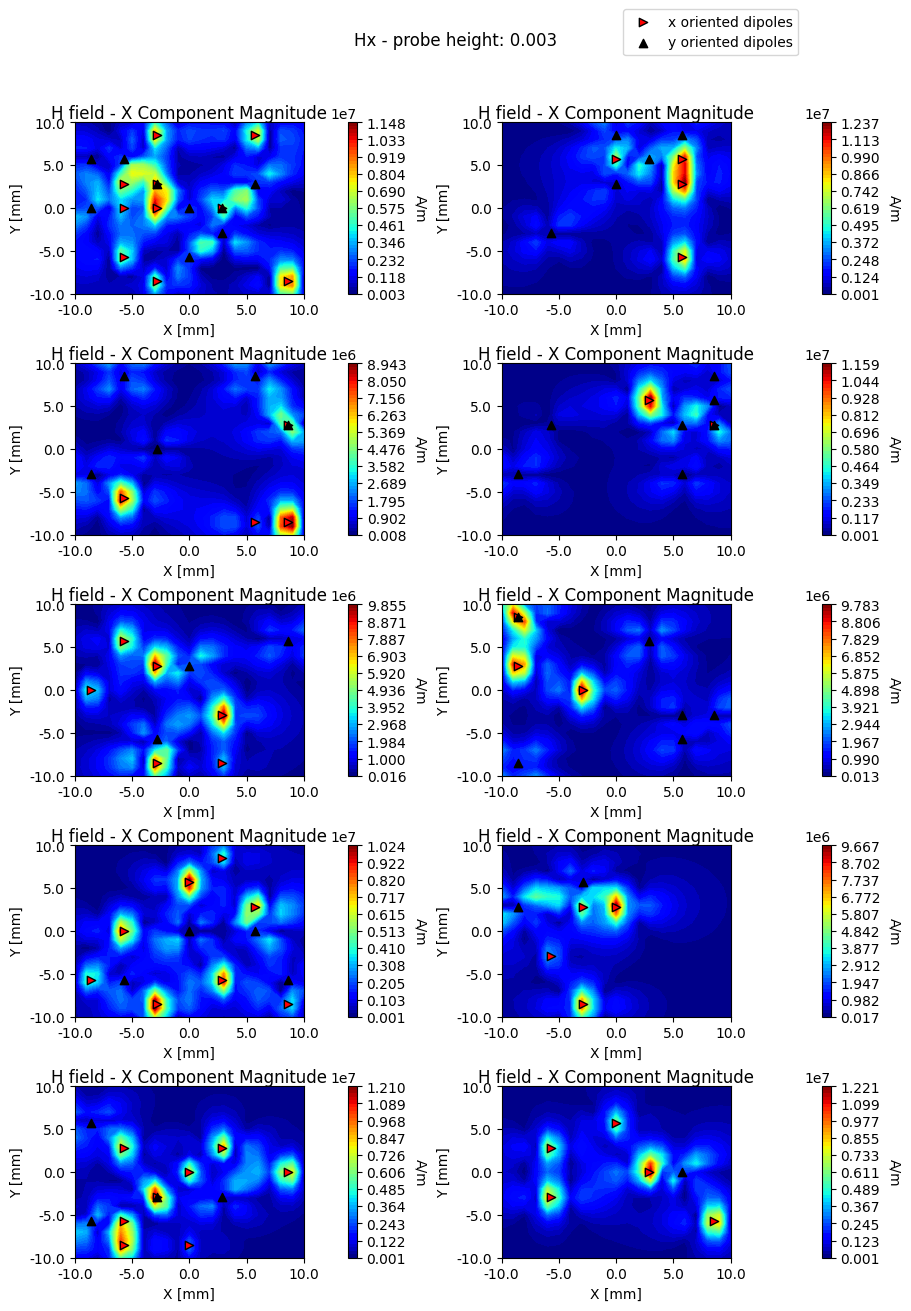

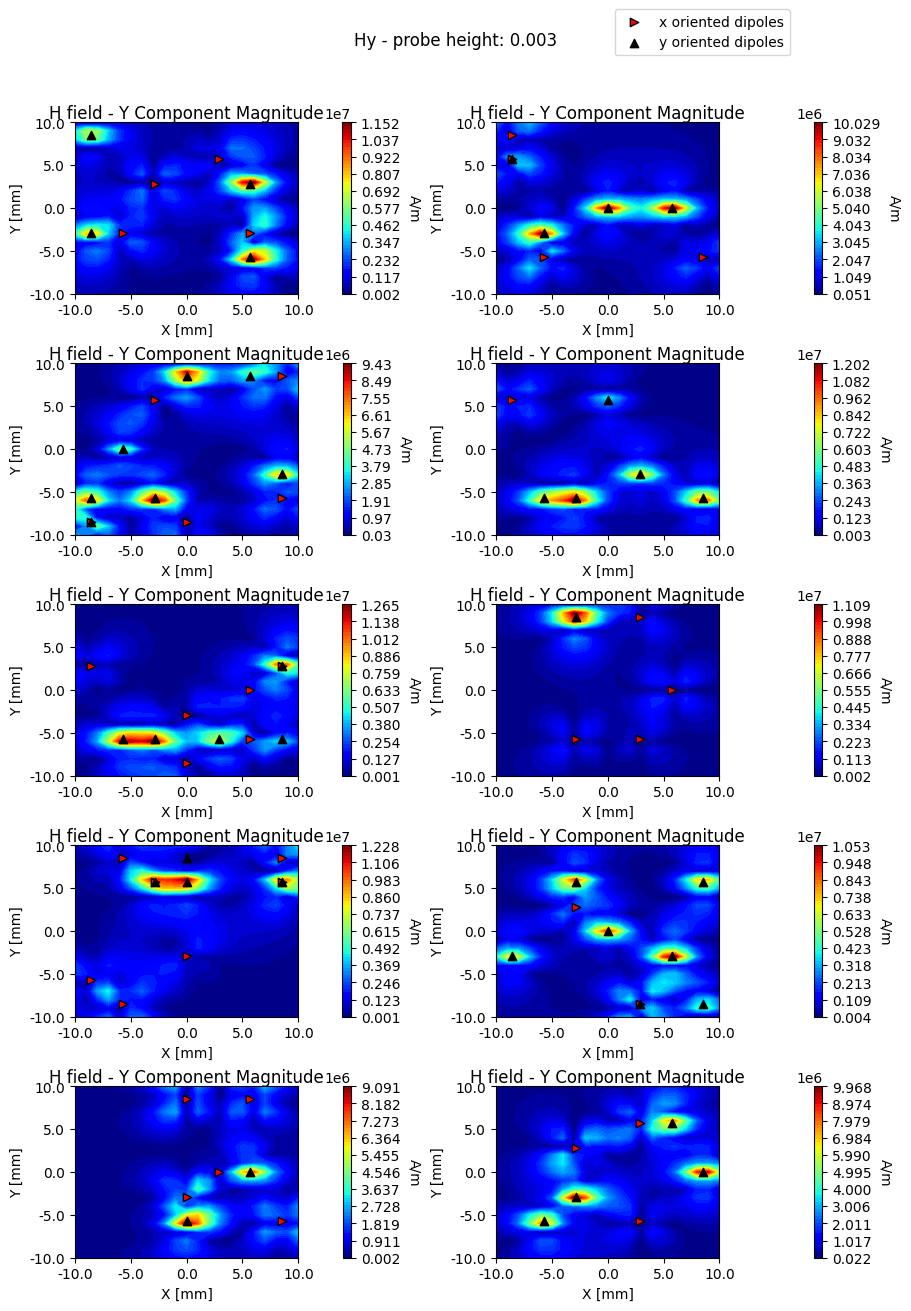

In [5]:
from my_packages.neural_network.data_generators.magnetic_array_generator import RandomMagneticDipoleGenerator
from my_packages.neural_network.data_generators.abstract import Generator

resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2

rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )


Hx, Hy = rmg.generate_random_H_fields()
FIGSIZE = (9, 13)

fig, ax = plt.subplots(5,2, figsize=FIGSIZE, constrained_layout=True)
image_folder = "images"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

for ii in range(10):
    Hx, _ = rmg.generate_random_H_fields()
    r0 = rmg._return_r0()
    Hx.plot(ax=ax.flatten()[ii])
    ax.flatten()[ii].scatter(rmg.r0x[:, 0], rmg.r0x[:, 1], c="r", marker=">", edgecolor="k", label="x oriented dipoles")
    ax.flatten()[ii].scatter(rmg.r0y[:, 0], rmg.r0y[:, 1], c="k", marker="^", label="y oriented dipoles")
ax.flatten()[1].legend(loc="upper left", bbox_to_anchor=(0.5, 1.7))
fig.suptitle("Hx - probe height: {}".format(probe_height), y=0.98)

fullpath = os.path.join(image_folder, "Hx_random_dipoles.png")
plt.savefig(fullpath, dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(5,2, figsize=FIGSIZE, constrained_layout=True)
for ii in range(10):
    _, Hy = rmg.generate_random_H_fields()
    r0 = rmg._return_r0()
    Hy.plot(ax=ax.flatten()[ii])
    ax.flatten()[ii].scatter(rmg.r0x[:,0], rmg.r0x[:,1], c="r", marker=">", edgecolor="k", label="x oriented dipoles")
    ax.flatten()[ii].scatter(rmg.r0y[:,0], rmg.r0y[:,1], c="k", marker="^", label="y oriented dipoles")
ax.flatten()[1].legend(loc="upper left", bbox_to_anchor=(0.5, 1.7))
fig.suptitle("Hy - probe height: {}".format(probe_height), y=0.98)


fullpath = os.path.join(image_folder, "Hy_random_dipoles.png")
plt.savefig(fullpath, dpi=300, bbox_inches="tight")



## Import Pytorch

In [6]:
import torch

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))

cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7fa674e6bfa0>
the device name is:  NVIDIA T600 Laptop GPU


In [76]:

class DataIterator:
    def __init__(self, generating_class, normalize=True):
        self.gen = generating_class
        self.normalize = normalize

    def __iter__(self):
        return self

    def __next__(self):
        labeled_data = self.gen.generate_labeled_data()
        
        if self.normalize:
            labeled_data = self._normalize_data(labeled_data)
        
        return labeled_data

    def _normalize_data(self, labeled_data):
        f, t = labeled_data
        if np.sum(t) == 0:
            return labeled_data
        min_value = np.min(f)
        max_value = np.max(f)
        normalized_f = (f - min_value) / (max_value - min_value)
        return normalized_f, t
    
    def generate_N_data_samples(self, N):
        f = []
        t = []
        for _ in range(N):
            samplef, samplet = next(self)
            f.append(samplef)
            t.append(samplet)
        f = np.asarray(f)
        t = np.asarray(t)
        return f, t

resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2

rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )




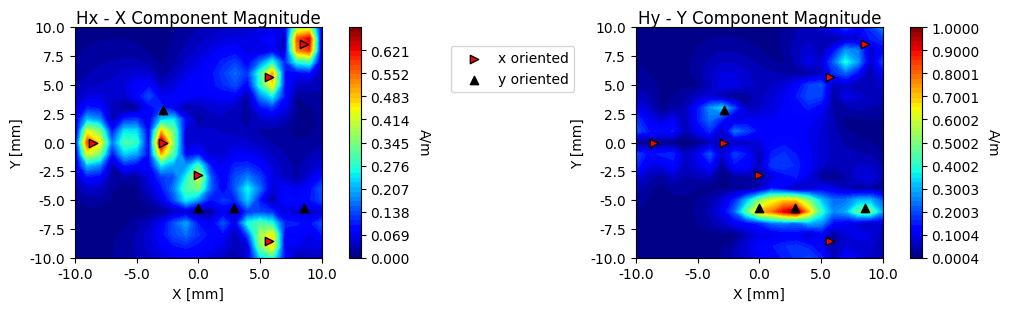

In [77]:
resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2

rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )

gen = DataIterator(rmg)
f, t = next(gen)
rmg.plot_labeled_data(fields=f, mask=t)

### Try Linear Regression

In [89]:
n_samples = int(1000)
f, t = gen.generate_N_data_samples(N=n_samples)
f = f.reshape(n_samples, -1)
t = t.reshape(n_samples, -1)

print(f.shape, t.shape)

(1000, 882) (1000, 98)


In [91]:
inputs = f
targets = t

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs).float()
targets = torch.from_numpy(targets).float()
print("input shape: ", inputs.shape)
print("output shape: ", targets.shape)

A = inputs.shape[-1]
B = targets.shape[-1]

# define the weight matrix 
W = torch.randn(A, B, dtype=torch.float, requires_grad=True)
b = torch.randn(B, dtype=torch.float, requires_grad=True)

estimation = inputs@W + b

print("estimation shape: ", estimation.shape)

input shape:  torch.Size([1000, 882])
output shape:  torch.Size([1000, 98])
estimation shape:  torch.Size([1000, 98])


loss:  tensor(27.1318, grad_fn=<DivBackward0>)
weight gradient shape:  torch.Size([882, 98])
bias gradient shape:  torch.Size([98])


Text(0.5, 1.0, 'weight gradient')

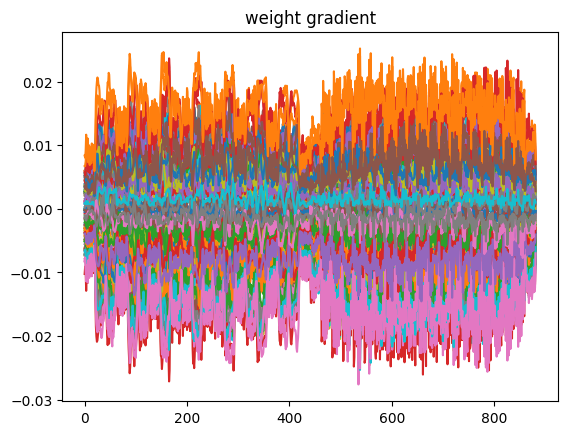

In [92]:
# based on the above results we can build a model

def model(x):
    return x@W + b

# let's define a loss function
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff*diff)/diff.numel()

# compute the loss of the random model
estimation = model(inputs)
loss = mse(estimation, targets)

print("loss: ", loss)

# we can use the pytorch built-ins to compute the gradients
loss.backward()

# the gradients are:
print("weight gradient shape: ", W.grad.shape)
print("bias gradient shape: ", b.grad.shape)

# plot the gradients
plt.figure()
plt.plot(W.grad, label="weight gradient");
plt.title("weight gradient")

In [93]:
# we now want to update the weights and biases
# we can do this manually
# learning_rate = 1e-5
# with torch.no_grad():
#     W -= W.grad * learning_rate
#     b -= b.grad * learning_rate

print("initial loss: ", loss)

# update the weights and biases
learning_rate = 1e-2
with torch.no_grad():
    W -= W.grad * learning_rate
    b -= b.grad * learning_rate
    W.grad.zero_()
    b.grad.zero_()
prediction = model(inputs)
loss = mse(prediction, targets)
print("updated loss: ", loss)


initial loss:  tensor(27.1318, grad_fn=<DivBackward0>)
updated loss:  tensor(27.0670, grad_fn=<DivBackward0>)


In [94]:
# perform linear regression with pytorch built-ins

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


inputs = f
targets = t

# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs).float()
targets = torch.from_numpy(targets).float()
print("input shape: ", inputs.shape)
print("output shape: ", targets.shape)

# define the dataset
train_ds = TensorDataset(inputs, targets)

# define the data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

sample = next(iter(train_dl))
print("sample shape: ", sample[0].shape, sample[1].shape)

input shape:  torch.Size([1000, 882])
output shape:  torch.Size([1000, 98])
sample shape:  torch.Size([5, 882]) torch.Size([5, 98])


In [95]:
# build the model
model = torch.nn.Linear(A, B)
print("the linear model contains the following parameters: ")
print("the weight matrix with shape: ", model.weight.shape)
print("the bias vector with shape: ", model.bias.shape)

# loss function
loss_fn = torch.nn.MSELoss()
# loss_categorical = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.BCEWithLogitsLoss()


# optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

# fit function
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    loss_history = []  # List to store the loss values
    
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        # Append the loss value to the history list
        loss_history.append(loss.item())
        
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    return loss_history

the linear model contains the following parameters: 
the weight matrix with shape:  torch.Size([98, 882])
the bias vector with shape:  torch.Size([98])


In [96]:
for a, b in train_dl:
    print(a.shape, b.shape)
    break

torch.Size([5, 882]) torch.Size([5, 98])


In [98]:
history = fit(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 0.0428
Epoch [20/100], Loss: 0.0554
Epoch [30/100], Loss: 0.0300
Epoch [40/100], Loss: 0.0277
Epoch [50/100], Loss: 0.0458
Epoch [60/100], Loss: 0.0306
Epoch [70/100], Loss: 0.0364
Epoch [80/100], Loss: 0.0344
Epoch [90/100], Loss: 0.0321
Epoch [100/100], Loss: 0.0270


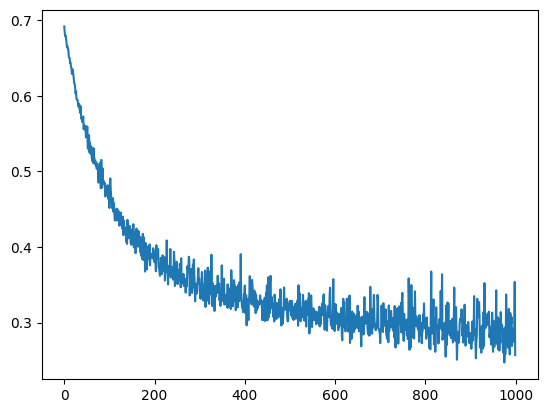

In [60]:
plt.plot(history)